In [0]:
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

**MNIST AE**

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)

#Get only first 1000 pictures for test
x_test=x_test[:1000]
y_test=y_test[:1000]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

trainloader_mnist = torch.utils.data.DataLoader(x_train, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader_mnist = torch.utils.data.DataLoader(x_test, batch_size=64,
                                         shuffle=False, num_workers=2)

[mnist] x_train.shape=(60000, 1, 28, 28), y_train.shape=(60000,)
[mnist] x_test.shape=(1000, 1, 28, 28), y_test.shape=(1000,)


In [0]:
x_train.shape

(60000, 1, 28, 28)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1):
        return input.view(input.size(0), size, 28, 28)

class AutoencoderMNIST(nn.Module):
    def __init__(self):
        super(AutoencoderMNIST, self).__init__()
        # Input size: [batch, 1, 28, 28]
        # Output size: [batch, 1, 28, 28]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),  
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            torch.nn.Linear(1152, 40)

            )
        
        self.decoder = nn.Sequential(

            nn.Linear(40, 28*7),
            nn.BatchNorm1d(28*7),
            nn.ReLU(),
            nn.Linear(28*7, 28*14),
            nn.BatchNorm1d(28*14),
            nn.ReLU(),
            nn.Linear(28*14, 28*28),
            UnFlatten()
            )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
from torch import device as device_
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 200
autoencoder = AutoencoderMNIST().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.to(device)
    return x

In [0]:
def train(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_mnist in enumerate(trainload):
          
            img = Variable(inputs_mnist).to(device)
            _, outputs_mnist = net(img)
            loss = criterion(outputs_mnist, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 900 == 899:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 900))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()

    end = time.time()
    print(f"Time cost for training (in seconds): {end-start}")

In [0]:
train(epochs, autoencoder, criterion, optimizer, trainloader_mnist, testloader_mnist,  scheduler=scheduler, verbose=True)

[1,   900] loss: 657.846
[1,    15] val_loss: 559.694
[2,   900] loss: 637.012
[2,    15] val_loss: 511.889
[3,   900] loss: 615.666
[3,    15] val_loss: 505.715
[4,   900] loss: 606.977
[4,    15] val_loss: 491.485
[5,   900] loss: 595.042
[5,    15] val_loss: 489.419
[6,   900] loss: 587.856
[6,    15] val_loss: 488.894
[7,   900] loss: 585.437
[7,    15] val_loss: 488.764
[8,   900] loss: 577.650
[8,    15] val_loss: 464.032
[9,   900] loss: 574.169
[9,    15] val_loss: 461.725
[10,   900] loss: 568.591
[10,    15] val_loss: 468.611
[11,   900] loss: 565.449
[11,    15] val_loss: 459.441
[12,   900] loss: 564.137
[12,    15] val_loss: 442.362
[13,   900] loss: 559.116
[13,    15] val_loss: 441.682
[14,   900] loss: 558.081
[14,    15] val_loss: 455.294
[15,   900] loss: 555.203
[15,    15] val_loss: 434.097
[16,   900] loss: 552.758
[16,    15] val_loss: 445.994
[17,   900] loss: 553.030
[17,    15] val_loss: 463.983
[18,   900] loss: 553.034
[18,    15] val_loss: 441.670
[19,   900

In [0]:
running_loss_val = 0.0
i = 0
reconstruction_time=[]
decoded_pics = []
testloader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)

with torch.no_grad():
    for data in testloader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = autoencoder.encoder(images)
        start=time.time()
        decoded_imgs = autoencoder.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append(end-start)
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the "naive" CNN+MLP AE on the 1000 test MNIST images: {running_loss_val/i}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the "naive" CNN+MLP AE on the 1000 test MNIST images: 324.1917419433594
Decoding time 0.00025558876991271974 is measured in sample per seconds


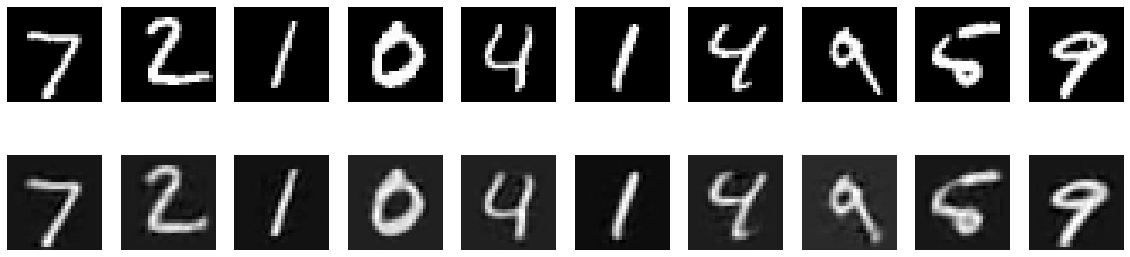

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_mnist:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray');
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(28, 28).astype(int), cmap='gray')
      ax[0, i].axis('off')
      ax[1, i].axis('off')

  break

**FULL CNN AE**

In [0]:
class Autoencoder3(nn.Module):
    def __init__(self,hid):
        super(Autoencoder3, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(1,4,kernel_size=5),
                        nn.BatchNorm2d(4),
                        nn.ReLU(True),

                        nn.Conv2d(4, 12, kernel_size=5),
                        nn.BatchNorm2d(12),
                        nn.ReLU(True),


                        nn.Conv2d(12, 16,kernel_size=5),
                        nn.BatchNorm2d(16),
                        nn.ReLU(True),

                        nn.Conv2d(16,28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),

                        nn.Conv2d(28, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),

                        nn.Conv2d(36, hid, kernel_size=5),
                        nn.BatchNorm2d(hid),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(hid, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(36, 28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),
 
                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(28, 16, kernel_size=5),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(16, 12, kernel_size=5),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(12, 4, kernel_size=5),
                        nn.ReLU(True),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(4, 1, kernel_size=5),
                        nn.ReLU(True))

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

In [0]:
net = Autoencoder3(70).to(device)
optimizer2 = torch.optim.Adam(net.parameters(), weight_decay=1e-5)
epochs = 200
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, epochs)

In [0]:
train(epochs, net, criterion, optimizer2, trainloader_mnist, testloader_mnist,  scheduler=scheduler2, verbose=True)

[1,   900] loss: 1364.507
[1,    15] val_loss: 561.776
[2,   900] loss: 535.954
[2,    15] val_loss: 408.605
[3,   900] loss: 421.635
[3,    15] val_loss: 331.024
[4,   900] loss: 359.664
[4,    15] val_loss: 322.740
[5,   900] loss: 315.663
[5,    15] val_loss: 268.244
[6,   900] loss: 285.317
[6,    15] val_loss: 241.685
[7,   900] loss: 259.814
[7,    15] val_loss: 216.027
[8,   900] loss: 239.605
[8,    15] val_loss: 202.893
[9,   900] loss: 222.521
[9,    15] val_loss: 181.071
[10,   900] loss: 205.735
[10,    15] val_loss: 178.534
[11,   900] loss: 192.660
[11,    15] val_loss: 164.531
[12,   900] loss: 181.250
[12,    15] val_loss: 151.244
[13,   900] loss: 170.535
[13,    15] val_loss: 147.716
[14,   900] loss: 161.656
[14,    15] val_loss: 152.927
[15,   900] loss: 153.285
[15,    15] val_loss: 130.854
[16,   900] loss: 145.308
[16,    15] val_loss: 128.386
[17,   900] loss: 139.584
[17,    15] val_loss: 123.318
[18,   900] loss: 132.720
[18,    15] val_loss: 109.671
[19,   90

In [0]:
running_loss_val = 0.0
i = 0
reconstruction_time = []
decoded_pics = []
testloader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)

with torch.no_grad():
    for data in testloader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = net.encoder(images)
        start=time.time()
        decoded_imgs = net.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append(end-start)
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the tunned CNN AE on the 1000 test MNIST images: {running_loss_val/i}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the tunned CNN AE on the 1000 test MNIST images: 17.589338302612305
Decoding time 0.0006199808120727539 is measured in sample per seconds


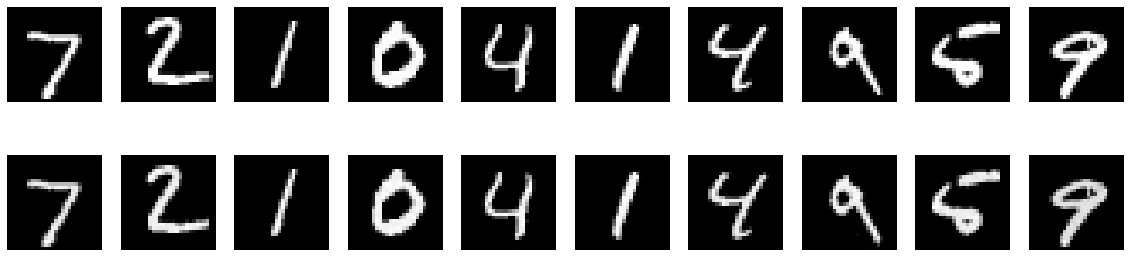

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_mnist:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray');
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(28, 28).astype(int), cmap='gray')
      ax[0, i].axis('off')
      ax[1, i].axis('off')

  break

**CIFAR CNN**

In [0]:
from keras.datasets import cifar10

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

x_train_cifar = x_train_cifar.reshape((x_train_cifar.shape[0], 3, 32, 32))
x_test_cifar = x_test_cifar.reshape((x_test_cifar.shape[0], 3, 32, 32))
y_train_cifar = y_train_cifar.reshape(-1)
y_test_cifar = y_test_cifar.reshape(-1)

#Get only first 1000 pictures for test
x_test_cifar=x_test_cifar[:1000]
y_test_cifar=y_test_cifar[:1000]

x_train_cifar = x_train_cifar.astype('float32')
x_test_cifar = x_test_cifar.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

batch = 64

[mnist] x_train.shape=(50000, 3, 32, 32), y_train.shape=(60000,)
[mnist] x_test.shape=(1000, 3, 32, 32), y_test.shape=(1000,)


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(), ])

trainloader_cifar = torch.utils.data.DataLoader(x_train_cifar, batch_size=batch,
                                          shuffle=True, num_workers=2)

testloader_cifar = torch.utils.data.DataLoader(x_test_cifar, batch_size=batch,
                                          shuffle=False, num_workers=2)

In [0]:
def train_cifar(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_cifar in enumerate(trainload):
          
            img = Variable(inputs_cifar).to(device)
            _, outputs_cifar = net(img)
            loss = criterion(outputs_cifar, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 750 == 749:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 750))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()
    end= time.time()
    print(f"Time cost for training (in seconds): {end-start} ")

**CNN + MLP AE**

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=3):
        return input.view(input.size(0), size, 32, 32)

class AutoencoderCIFAR_NAIVE(nn.Module):
    def __init__(self):
        super(AutoencoderCIFAR_NAIVE, self).__init__()
        # Input size: [batch, 1, 28, 28]
        # Output size: [batch, 1, 28, 28]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),           # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            torch.nn.Linear(192, 100)

            )
        
        self.decoder = nn.Sequential(

            nn.Linear(100, 3*32*8),
            nn.BatchNorm1d(3*32*8),
            nn.ReLU(),
            nn.Linear(3*32*8, 3*32*16),
            nn.BatchNorm1d(3*32*16),
            nn.ReLU(),
            nn.Linear(3*32*16, 3*32*32),
            UnFlatten()
            )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 200
autoencoder_cifar_naive = AutoencoderCIFAR_NAIVE().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder_cifar_naive.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [0]:
train_cifar(epochs, autoencoder_cifar_naive, criterion, optimizer, trainloader_cifar, testloader_cifar,  scheduler=scheduler, verbose=True)

[1,   750] loss: 3947.455
[1,    15] val_loss: 2201.282
[2,   750] loss: 2121.087
[2,    15] val_loss: 1899.839
[3,   750] loss: 1700.527
[3,    15] val_loss: 1555.166
[4,   750] loss: 1530.159
[4,    15] val_loss: 1361.479
[5,   750] loss: 1309.622
[5,    15] val_loss: 1196.486
[6,   750] loss: 1158.490
[6,    15] val_loss: 1071.075
[7,   750] loss: 1059.837
[7,    15] val_loss: 971.609
[8,   750] loss: 969.712
[8,    15] val_loss: 883.542
[9,   750] loss: 903.963
[9,    15] val_loss: 868.874
[10,   750] loss: 855.044
[10,    15] val_loss: 839.798
[11,   750] loss: 819.670
[11,    15] val_loss: 786.136
[12,   750] loss: 783.740
[12,    15] val_loss: 789.448
[13,   750] loss: 750.898
[13,    15] val_loss: 742.856
[14,   750] loss: 720.526
[14,    15] val_loss: 741.911
[15,   750] loss: 696.777
[15,    15] val_loss: 732.628
[16,   750] loss: 674.401
[16,    15] val_loss: 646.714
[17,   750] loss: 654.469
[17,    15] val_loss: 655.110
[18,   750] loss: 644.098
[18,    15] val_loss: 650.6

In [0]:
running_loss_val = 0.0
i = 0
decoded_pics = []
reconstruction_time = []

test_loader = torch.utils.data.DataLoader(x_test_cifar, batch_size=1, shuffle=False, num_workers=2)

with torch.no_grad():
    for data in test_loader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = autoencoder_cifar_naive.encoder(images)
        start=time.time()
        decoded_imgs = autoencoder_cifar_naive.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append((end-start))
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the CNN + MLP AE on the 1000 test CIFAR10 images: {running_loss_val/i}')
print(f"Decoding time {mean} is measured in seconds per sample")

MSE of the CNN + MLP AE on the 1000 test CIFAR10 images: 420.957275390625
Decoding time 0.0002514047622680664 is measured in seconds per sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


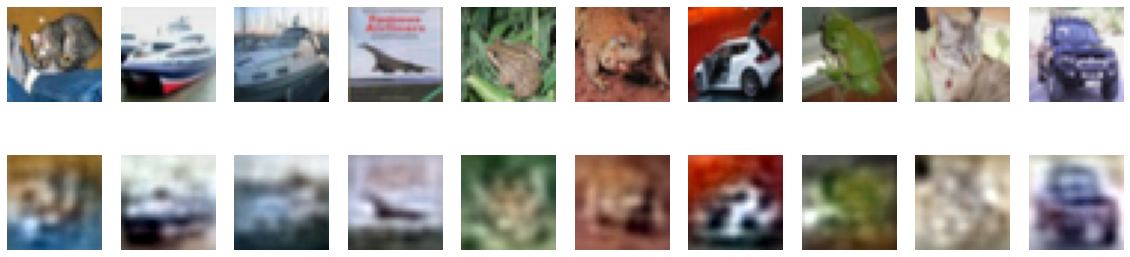

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_cifar:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.numpy().reshape(32, 32, 3).astype(int));
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(32, 32, 3).astype(int))
      ax[0, i].axis('off')
      ax[1, i].axis('off')

  break

**TUNNED CNN AE**

In [0]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=5),
                        nn.BatchNorm2d(32),
                        nn.ReLU(True),

                        nn.Conv2d(32, 64, kernel_size=5),
                        nn.BatchNorm2d(64),
                        nn.ReLU(True),


                        nn.Conv2d(64, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),

                        nn.Conv2d(128, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),

                        nn.Conv2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(

                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(256, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(128, 64, kernel_size=5),
                        nn.ReLU(True),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(64, 32, kernel_size=5),
                        nn.ReLU(True),
                        
                        nn.ConvTranspose2d(32, 3, kernel_size=5),
                        nn.ReLU(True))
                        

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MSEs_cifar = []

p = 0
print(f"Modeling with DropOut p = {p}")
epochs = 100
autoencoder_cifar =Autoencoder3().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder_cifar.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
train_cifar(epochs, autoencoder_cifar, criterion, optimizer, trainloader_cifar, testloader_cifar,  scheduler=scheduler, verbose=True)

running_loss_val = 0.0
i = 0
decoded_pics = []
reconstruction_time = []

test_loader = torch.utils.data.DataLoader(x_test_cifar, batch_size=1, shuffle=False, num_workers=2)

with torch.no_grad():
    for data in test_loader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = autoencoder_cifar.encoder(images)
        start=time.time()
        decoded_imgs = autoencoder_cifar.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append((end-start))
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

print(f'MSE of the tunned CNN AE on the 1000 test CIFAR images with dropout p = {p} is: {running_loss_val/i}')
MSEs_cifar.append(running_loss_val/i)


Modeling with DropOut p = 0
[1,   750] loss: 2835.225
[1,    15] val_loss: 1566.320
[2,   750] loss: 1176.113
[2,    15] val_loss: 767.792
[3,   750] loss: 706.810
[3,    15] val_loss: 668.537
[4,   750] loss: 546.637
[4,    15] val_loss: 532.859
[5,   750] loss: 463.678
[5,    15] val_loss: 373.214
[6,   750] loss: 395.240
[6,    15] val_loss: 417.083
[7,   750] loss: 339.797
[7,    15] val_loss: 441.516
[8,   750] loss: 295.868
[8,    15] val_loss: 219.952
[9,   750] loss: 270.341
[9,    15] val_loss: 267.078
[10,   750] loss: 242.835
[10,    15] val_loss: 223.420
[11,   750] loss: 218.695
[11,    15] val_loss: 208.001
[12,   750] loss: 209.802
[12,    15] val_loss: 229.987
[13,   750] loss: 195.386
[13,    15] val_loss: 222.979
[14,   750] loss: 192.367
[14,    15] val_loss: 189.523
[15,   750] loss: 176.394
[15,    15] val_loss: 122.405
[16,   750] loss: 172.832
[16,    15] val_loss: 179.167
[17,   750] loss: 159.427
[17,    15] val_loss: 121.711
[18,   750] loss: 149.831
[18,    1

Text(0, 0.5, '$CNN_2$')

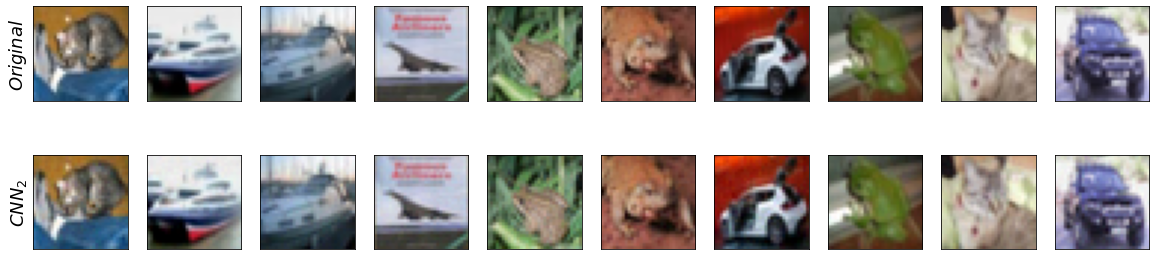

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_cifar:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.numpy().reshape(32, 32, 3).astype(int));
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(32, 32, 3).astype(int))
      ax[0, i].get_xaxis().set_ticks([])
      ax[0, i].get_yaxis().set_ticks([])
      ax[1, i].get_xaxis().set_ticks([])
      ax[1, i].get_yaxis().set_ticks([])

  break
ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
ax[1, 0].set_ylabel(f"$CNN_2$",fontsize=18)